In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import spline, BSpline
import scipy.interpolate as interpolate
import numpy as np
sns.set(style="ticks")
print("pd version", pd.__version__)
print("seaborn version", sns.__version__)
print("numpy version", np.__version__)

pd version 0.24.2
seaborn version 0.9.0
numpy version 1.16.2


### Trellis plots with résumé data

1. Create my own small dataset, import CSV
2. Smooth my own small dataset
3. Plot on trellis
4. Start styling like the joyplot trellis

### Import and shape the data

In [2]:
# Import csv, fill all empty cells with zero
# It's easier to fill out the spreadsheet with empty cells instead of zeros
activity_table = pd.read_csv("activity.csv").fillna(0)
activity_table

,year,Physics Research,C,Mathematica,Machine Learning,Teaching,Perl,Web Apps,Websites,JS / TS / Node / Coffee,Data Pipelines,Design,Leading Dev Teams,Data Visualization,Python,Clojure & CLJS
0,1992,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1993,5.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1994,5.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1995,5.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1996,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1997,7.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1998,7.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1999,10.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2000,10.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2001,10.0,1.0,0.0,0.0,4.0,7.0,4.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Reshape by melt: 
# https://pandas.pydata.org/pandas-docs/stable/reshaping.html#reshaping-by-melt
activity = activity_table.melt(id_vars=['year']).rename(columns = {'variable': 'skill', 'value': 'intensity'})

### Interpolate data as spline curve

In [4]:
# Group data by activity. This is so each group can be run through the 
# spline function and recombined later
activity_grouped = activity.groupby(by="skill", sort=False)
# activity_grouped.describe()

In [5]:
def to_spline(x, y, samples=300):
    """Pass in the x and y data. 
    Return x and y data that has expanded data points and curvy"""
    x_new = np.linspace(x.min(), x.max(), samples)
    t, c, k = interpolate.splrep(x, y, s=0, k=4)
    y_spline = interpolate.BSpline(t, c, k, extrapolate=False)
    y_new = y_spline(x_new)
    return (x_new, y_new)

In [6]:
# Iterate over every group, sending each group to the spline function
# Append the results to a new dataframe
activity_splined = pd.DataFrame()
for key, item in activity_grouped:
    x, y = to_spline(activity_grouped.get_group(key).year, activity_grouped.get_group(key).intensity)
    
    # When interpolating, the end of a sharp curve goes below zero and then back above zero
    # While mathematically correct, it doesn't reflect my data. So cut off those small waves    
    y[y < 0.5] = 0 
    df = pd.DataFrame({
        "year": x,
        "intensity": y,
        "activity": np.repeat(key, len(x))
    })
    activity_splined = activity_splined.append(df, ignore_index=True)
    

# activity_splined[activity_splined.activity == "C"].describe()
activity_splined[activity_splined.activity == "Physics Research"].iloc[80:95]


,year,intensity,activity
80,1999.224080,10.220316,Physics Research
81,1999.314381,10.207679,Physics Research
82,1999.404682,10.152400,Physics Research
83,1999.494983,10.071299,Physics Research
84,1999.585284,9.985508,Physics Research
85,1999.675585,9.916168,Physics Research
86,1999.765886,9.879578,Physics Research
87,1999.856187,9.886678,Physics Research
88,1999.946488,9.943042,Physics Research
89,2000.036789,10.048886,Physics Research


/Users/jeff/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jeff/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jeff/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jeff/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


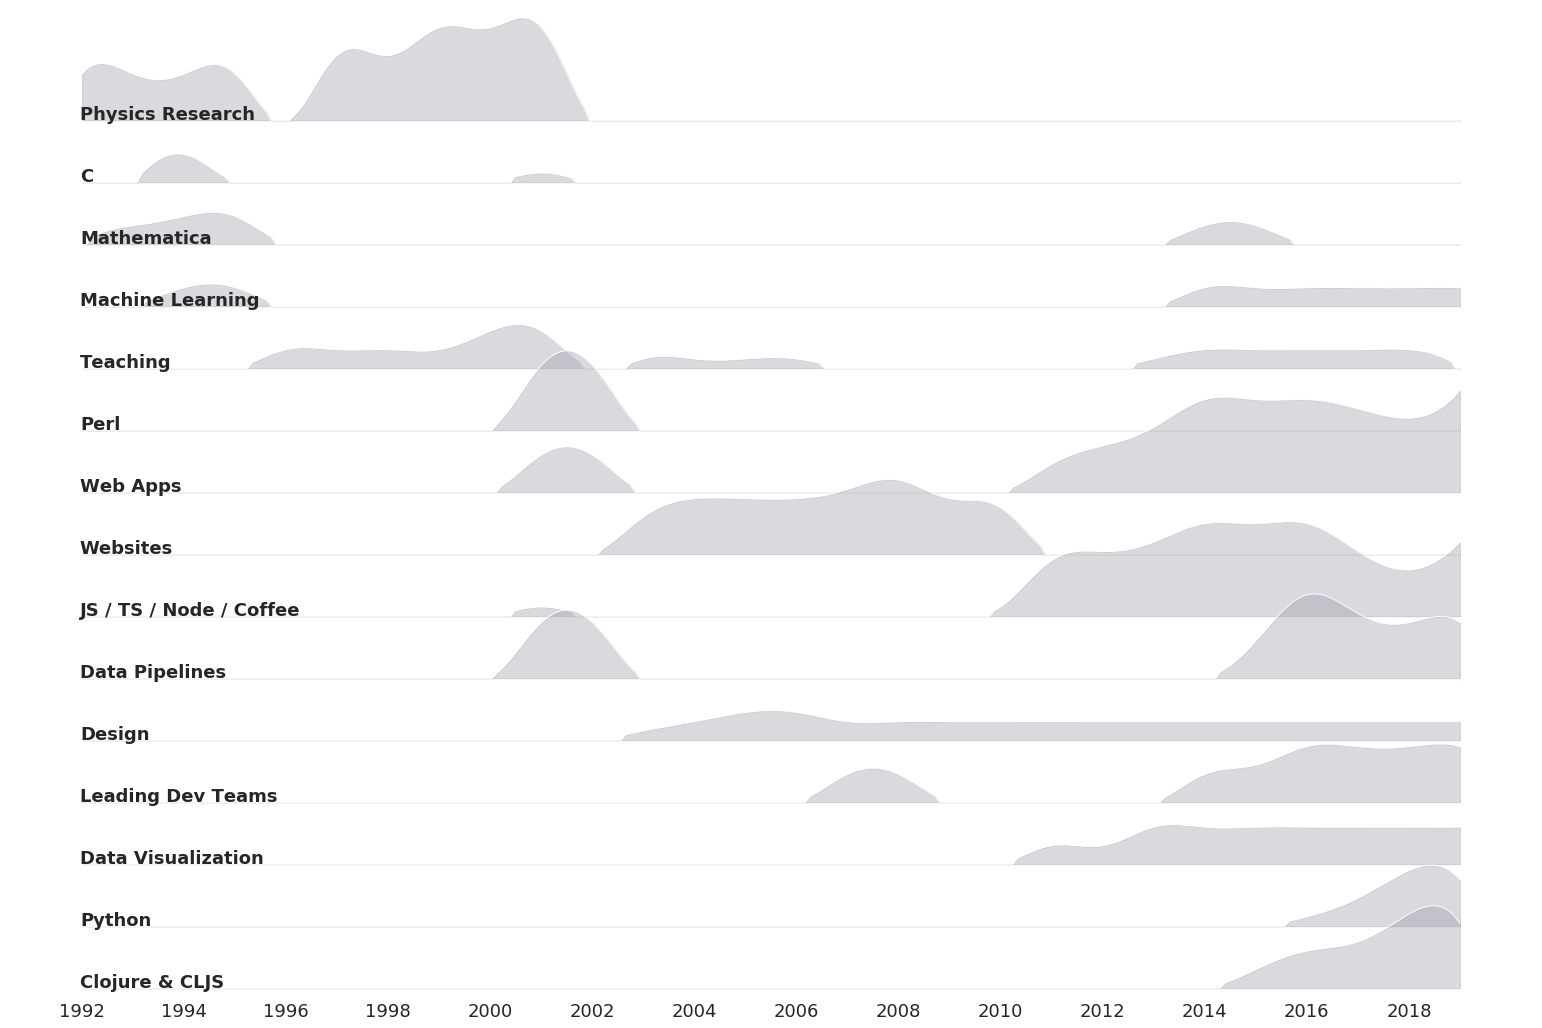

In [7]:
def joyplot(df, row="row", x="x", y="y", xlim_range=None, xticks=None, ylim_range=None, 
            xlabel_text=None, save_name=False):
    
    # The look and feel of the joyplot is greatly influenced by the facent and subplot dimenensions
    facet_aspect = 22    # facet_aspect*facet_height => width of each facet in inches 
    facet_height = 1
    subplot_hspace = -0.45
    
    row_label_fontsize = 18
    x_axis_tick_size = 18
    shape_color = "#A1A1AD"         # blue-tinged grey
    # shape_color = "#8484AD"       # visibly light blue
    use_shape_fill = True
    # shape_fill_alpha = 0.3        # lighter for online viewing
    shape_fill_alpha = 0.4          # darker for printing
    # shape_line_color = "#A1A1AD"  # lighter for online viewing
    # shape_line_color = "#92929A"    # darker for printing
    shape_line_color = "#ffffff"    # white because it looks a little better
    shape_line_width = 1
    axis_line_width = 0
    sns.set(style = "white", rc = {"axes.facecolor": (0, 0, 0, 0),
                                   "font.family": "Lato",
                                   "font.size": row_label_fontsize,
                                   "xtick.labelsize": x_axis_tick_size,
                                   "figure.facecolor": "ffffff"})
    
    # Initialize the FacetGrid object
    pal = sns.color_palette([shape_color])
    row_order = df[row].unique()
    g = sns.FacetGrid(df, row=row, hue=row, palette=pal, row_order=row_order,
                      aspect=facet_aspect, height=facet_height)

    # Draw the plots in a few steps
    if shape_line_width > 0:
        g = g.map(plt.plot, x, y, color=shape_line_color, linewidth=shape_line_width)
    if use_shape_fill:
        g = g.map(plt.fill_between, x, y, alpha=shape_fill_alpha)
    if axis_line_width > 0:
        g = g.map(plt.axhline, y=0, linewidth=axis_line_width, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(.044, .1, label, fontweight="bold", horizontalalignment="left",
                verticalalignment="center", transform=ax.transAxes)
    g = g.map(label, row)

    # Set the subplots to overlap to get the Joyplot effect
    g.fig.subplots_adjust(hspace=subplot_hspace)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    if xticks:
        g.set(xticks=x_axis_ticks)
    else:
        g.set(xticks=np.arange(df[x].min(), df[x].max() + 1, 2))
    if xlim_range:
        g.set(xlim = xlim_range)
    if ylim_range:
        g.set(ylim = ylim_range)
    if xlabel_text:
        plt.xlabel(xlabel_text, labelpad = 15)
    else:
        plt.xlabel("")
    if save_name:
        g.fig.savefig(save_name + ".svg", transparent=True)
    
    
joyplot(activity_splined, row="activity", x="year", y="intensity", save_name="activities_joyplot")